# Data Exploration: Anti-Money Laundering System
## 🧭 Project Context

This notebook is part of a broader end-to-end **Anti-Money Laundering (AML)** project that integrates:

- Apache Kafka for real-time transaction streaming
- A Machine Learning pipeline for fraud detection
- A Gradio dashboard for risk monitoring and explainability
---
## 📁 Dataset: PaySim Synthetic Financial Transaction (kaggle)
We utilize the [PaySim dataset](https://www.kaggle.com/datasets/ealaxi/paysim1), which simulates mobile money transactions based on real-world financial logs. It includes ~6 million transactions labeled with:
- **step**: The dataset simulates 30 days of transactions (744 hours)
- **isFraud**: Whether the transaction is fraudulent
- **isFlaggedFraud**: Flagged based on predefined business rules
- Transaction types such as: `CASH-IN`, `CASH-OUT`, `TRANSFER`, `PAYMENT`, and `DEBIT`
- Features include transaction amount, and account balances before and after transactions
---
## 📌 Goals of this Notebook
1. **Understand the structure and distribution** of transaction types, amounts, and risk labels.
2. **Visualize imbalances and relationships** between fraud indicators and transaction behavior.
3. **Engineer useful features** that can improve model accuracy.
4. **Validate alignment** with the custom synthetic transaction generator for streaming.
---
## 🔄 Integration Plan
This exploration phase will inform:
- **Model Training** in `model_training.ipynb`
- **Streaming Simulator** via `TransactionGenerator`
- **Kafka + Gradio Integration** for real-time detection and dashboarding
---
Let's begin by loading and inspecting the data.

### 1. Prepare dataset

In [1]:
import numpy as np
import pandas as pd
path = '../data/paysim_synthetic.csv'
data = pd.read_csv(path)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


### 2. Data Exploration
#### 2.1 Descriptive Statistics

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
print('Number of transactions: ', len(data))

Number of transactions:  6362620


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [6]:
data.duplicated().sum()

0

In [7]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [9]:
data[data['isFraud'] == 1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

> Now let's check how many transactions are fraudulent.

In [20]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
data['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [22]:
data['nameOrig'].value_counts().sort_index(ascending=False)

C999999784     1
C999999614     1
C999999254     1
C999998175     1
C999996999     1
              ..
C1000003372    1
C1000002591    1
C1000001725    1
C1000001337    1
C1000000639    1
Name: nameOrig, Length: 6353307, dtype: int64

In [9]:
print('\n The types of fraudulent transactions are {}'.format(\
list(data.loc[data.isFraud == 1].type.drop_duplicates().values)))

dataFraudTransfer = data.loc[(data.isFraud == 1) & (data.type == 'TRANSFER')]
dataFraudCashout = data.loc[(data.isFraud == 1) & (data.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dataFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dataFraudCashout)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


> We can see that fraudulent transactions are extremely rare. This also means we are dealing with a highly imbalanced dataset with only 0.13% fraudulent transactions.

#### 2.2 Data Visualization

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

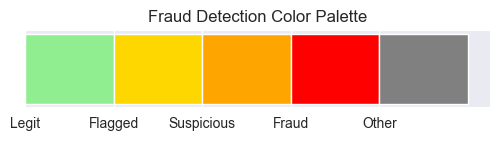

In [12]:
# Define a color palette with 5 distinguishable colors for fraud analysis
fraud_palette = [
    mcolors.CSS4_COLORS['lightgreen'],   # Legitimate
    mcolors.CSS4_COLORS['gold'],         # Flagged (rule-based)
    mcolors.CSS4_COLORS['orange'],       # Suspicious
    mcolors.CSS4_COLORS['red'],          # Confirmed Fraud
    mcolors.CSS4_COLORS['gray']          # Unknown or Others
]

# Optional: Display the palette
plt.figure(figsize=(6, 1))
for i, color in enumerate(fraud_palette):
    plt.barh(0, 1, left=i, color=color)
plt.yticks([])
plt.xticks(range(5), ['Legit', 'Flagged', 'Suspicious', 'Fraud', 'Other'])
plt.title("Fraud Detection Color Palette")
plt.show()

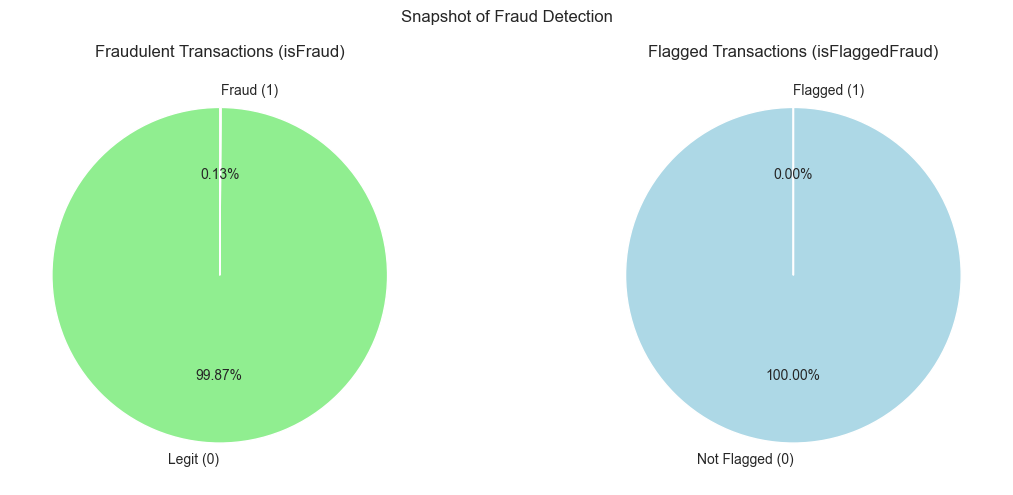

In [12]:
# Plot side by side pie charts - distribution of isFraud and isFlaggedFraud
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart for isFraud
fraud_counts = data['isFraud'].value_counts()

axs[0].pie(
    fraud_counts,
    labels = ['Legit (0)', 'Fraud (1)'],
    autopct='%1.2f%%',
    colors = ['lightgreen', 'red'],
    startangle = 90
)

axs[0].set_title("Fraudulent Transactions (isFraud)")

# Pie chart for isFlaggedFraud
flagged_counts = data['isFlaggedFraud'].value_counts()

axs[1].pie(
    flagged_counts,
    labels = ['Not Flagged (0)', 'Flagged (1)'],
    autopct='%1.2f%%',
    colors = ['lightblue', 'orange'],
    startangle = 90
)

axs[1].set_title("Flagged Transactions (isFlaggedFraud)")

plt.suptitle("Snapshot of Fraud Detection")
plt.tight_layout()
plt.show()

#### Visualizing Transaction Types

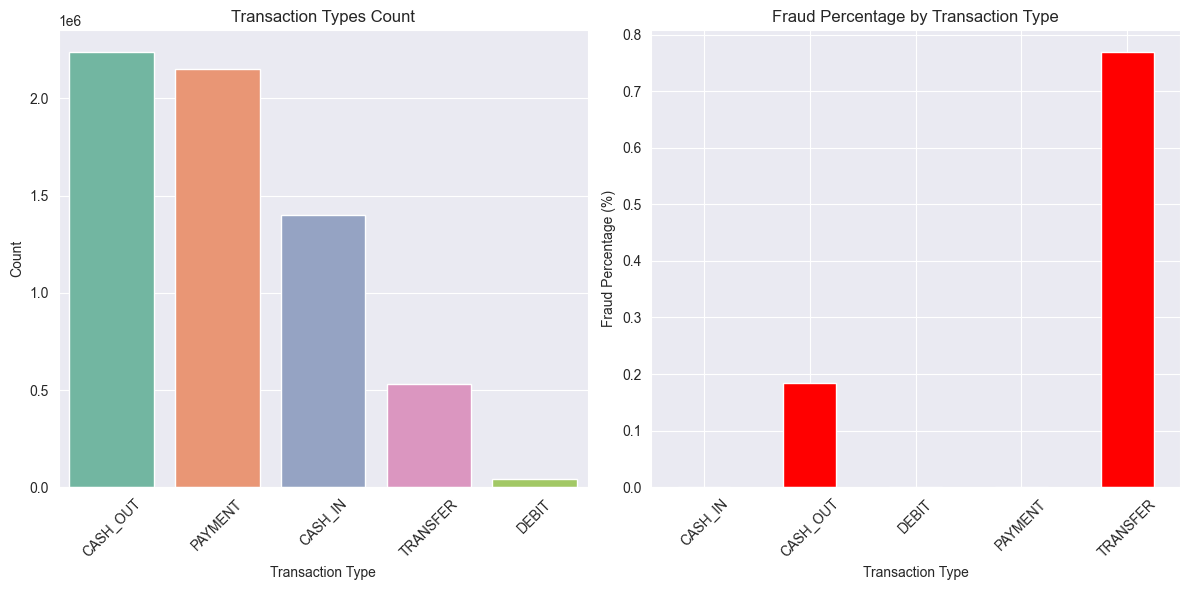

In [26]:
# Transaction types and fraud
fraud_by_type = data.groupby('type')['isFraud'].mean() * 100

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='type', order=data['type'].value_counts().index, palette='Set2')
plt.title("Transaction Types Count")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
fraud_by_type.plot(kind='bar', color='red')
plt.title("Fraud Percentage by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Percentage (%)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

> It looks like most transactions are `CASH_OUT`, `PAYMENT` and `CASH_IN` in nature. But the ones that are most prone to fraud are `TRANSFER`, followed by `CASH_OUT`.

#### Amount Distribution Analysis

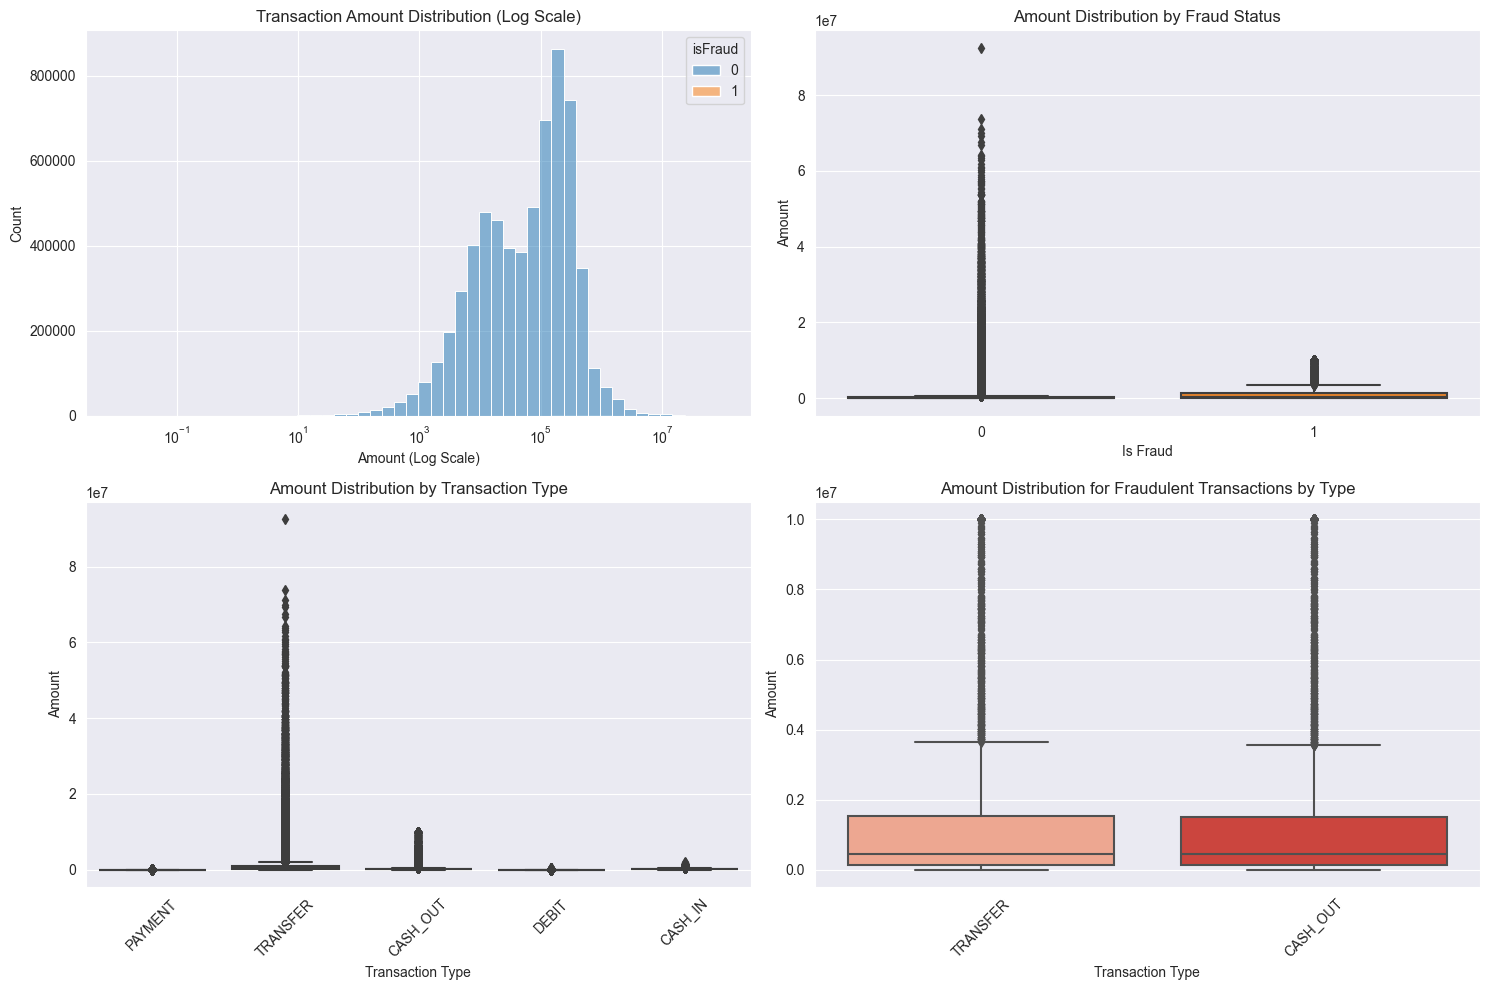

In [14]:
# Amount distribution analysis
# Ensure amount is not 0
data1 = data[data['amount'] > 0]

# Plot figures
plt.figure(figsize=(15, 10))

# Create a grid for subplots
gs = gridspec.GridSpec(2, 2)

# Overall amount distribution (log scale)
ax0 = plt.subplot(gs[0, 0])
sns.histplot(data=data1, x='amount', hue='isFraud', bins=50, log_scale=True, ax=ax0)
ax0.set_title('Transaction Amount Distribution (Log Scale)')
ax0.set_xlabel('Amount (Log Scale)')
ax0.set_ylabel('Count')

# Amount distribution for fraud vs non-fraud
ax1 = plt.subplot(gs[0, 1])
sns.boxplot(x='isFraud', y='amount', data=data, ax=ax1)
ax1.set_title('Amount Distribution by Fraud Status')
ax1.set_xlabel('Is Fraud')
ax1.set_ylabel('Amount')

# Amount by transaction type
ax2 = plt.subplot(gs[1, 0])
sns.boxplot(x='type', y='amount', data=data, ax=ax2)
ax2.set_title('Amount Distribution by Transaction Type')
ax2.set_xlabel('Transaction Type')
ax2.set_ylabel('Amount')
ax2.tick_params(axis='x', rotation=45)

# Amount distribution for fraudulent transactions by type
ax3 = plt.subplot(gs[1, 1])
fraud_data = data[data['isFraud'] == 1]
sns.boxplot(x='type', y='amount', data=fraud_data, ax=ax3, palette='Reds')
ax3.set_title('Amount Distribution for Fraudulent Transactions by Type')
ax3.set_xlabel('Transaction Type')
ax3.set_ylabel('Amount')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
# plt.savefig("AmountDistributionAnalysis.png", dpi=300)
plt.show()

1. Transaction Amount Distribution (Log Scale Histogram)
> The distribution is heavily right-skewed, with the bulk of transactions clustering around 10^3 - 10^5 ($1,000 to 100,000). The plot is dominated by blue bars, and no visible red bars. Since fraudulent transactions are rarer, they're likely being visually overshadowed by low fraud ratio.

2. Amount Distribution by Fraud Status (Boxplot)
> Fraudulent transactions have shorter whisker and fewer extreme outliers. Non-fraud transactions span much larger values and have more high-end outliers. We can see that fraudulent transactions are not necessarily the largest ones (many large transactions are legitimate). Instead, fraud may hide in mid-high ranges, or exploit transaction patterns more subtly.

3. Amount Distributioon by Transaction Type (Boxplot)
> `TRANSFER` has the widest spread and most extreme outliers, suggesting high variability. This makes sense since fund transfers are often higher in risk since it permits large values and greater abuse potential. But this does not mean its always fraudulent in nature.

4. Amount Distribution for Fraudulent Transaction Type (Boxplot)
> Fraud occurs exclusively in `TRANSFER` and `CASH_OUT` payment types. We can see fairly tight boxplots for these 2 types, with median values below $2mil. Transactions higher than this threshold may be flagged for anomaly detection. This tight distribution also implies that fraudsters may repeat similar patterns or exploit this threshold to commit fraud.

Now we can dive a little deeper into transaction amounts that are fraudulent.

#### Fraud vs Flagged Fraud Amount Distribution Analysis

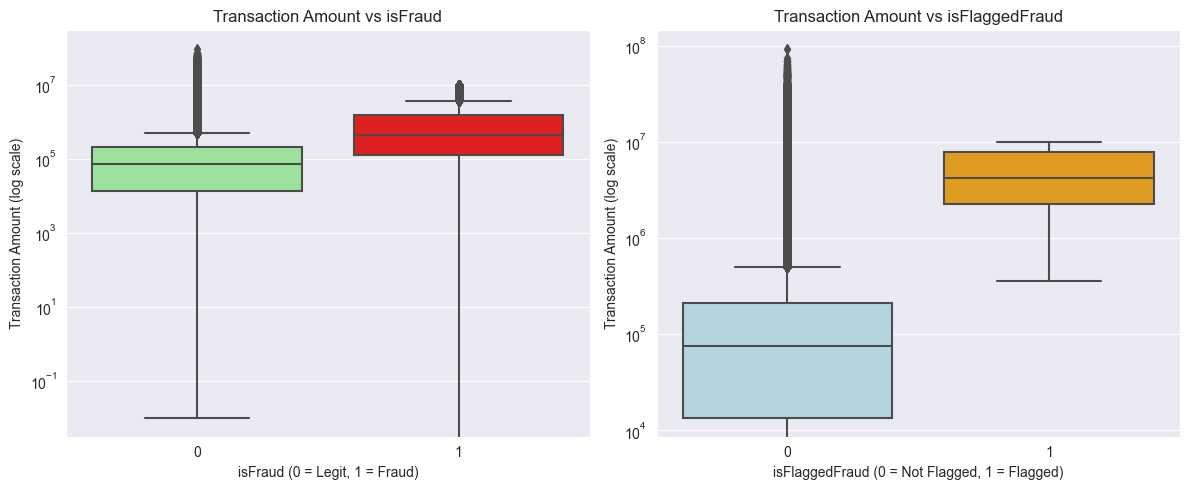

In [13]:
# Plot Amount vs isFraud
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=data, x='isFraud', y='amount', palette=['lightgreen', 'red'])
plt.yscale('log')
plt.title("Transaction Amount vs isFraud")
plt.xlabel("isFraud (0 = Legit, 1 = Fraud)")
plt.ylabel("Transaction Amount (log scale)")

# Plot Amount vs isFlaggedFraud
plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='isFlaggedFraud', y='amount', palette=['lightblue', 'orange'])
plt.yscale('log')
plt.title("Transaction Amount vs isFlaggedFraud")
plt.xlabel("isFlaggedFraud (0 = Not Flagged, 1 = Flagged)")
plt.ylabel("Transaction Amount (log scale)")

plt.tight_layout()
plt.show()

**Left plot: Transaction Amount vs isFraud**
<br>Fraudulent transactions (isFraud=1) have higher median and tigher range compared to legitimate ones (isFraud=0). This further confirms our earlier insight and draw a likely assumption that fraudsters typically operate within a specific high range while staying below detection thresholds. High value fraud may exist but not at extreme high values.

**Right plot: Transaction Amount vs isFlaggedFraud**
<br>Flagged transactions (isFlaggedFraud=1) appear to have significantly higher amount at around 500,000+, with tight IQR. Non-flagged transactions (isFlaggedFraud=0) span a wider range, including very low values and long tail with extreme outliers.
<br>The flagging mechanism seems to be relying on a specific amount–possibly a hard threshold rule.

#### Account Type and Balance Analysis

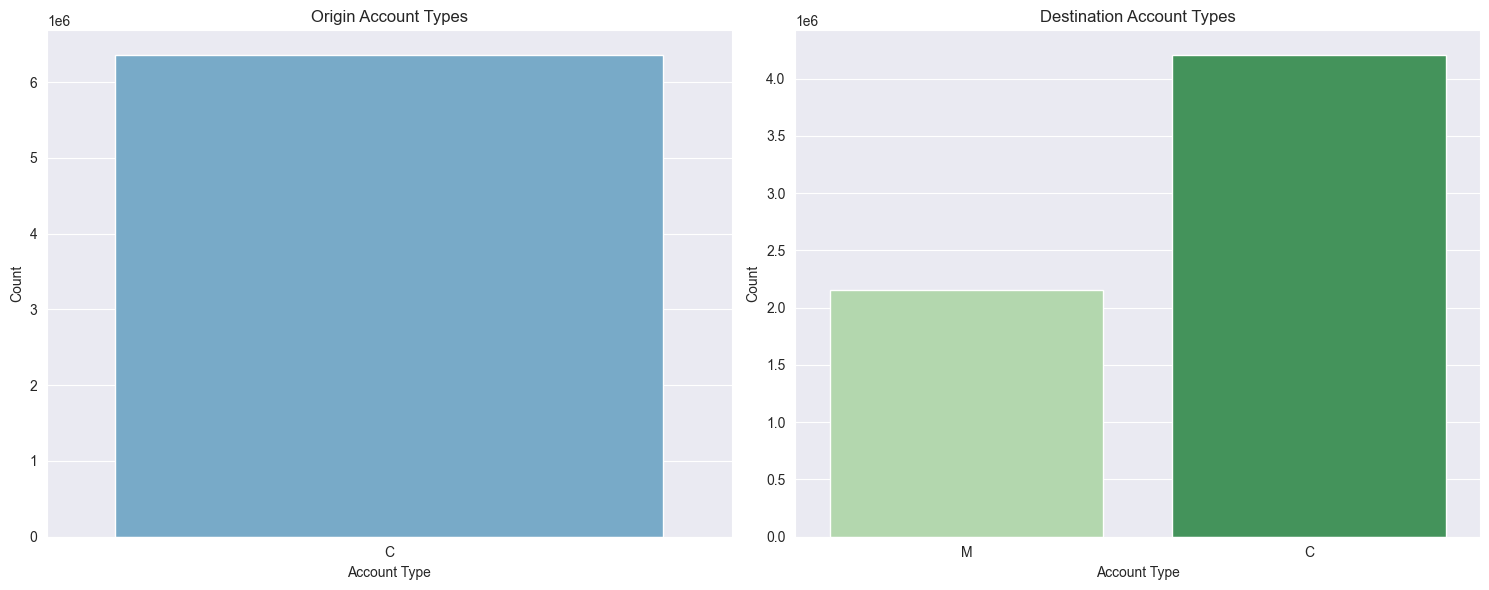

In [35]:
# Analyze origin and destination accounts
# First, extract account types from nameOrig and nameDest
data['originAccountType'] = data['nameOrig'].str[0]
data['destAccountType'] = data['nameDest'].str[0]

# Visualize account types
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='originAccountType', data=data, palette='Blues')
plt.title('Origin Account Types')
plt.xlabel('Account Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='destAccountType', data=data, palette='Greens')
plt.title('Destination Account Types')
plt.xlabel('Account Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

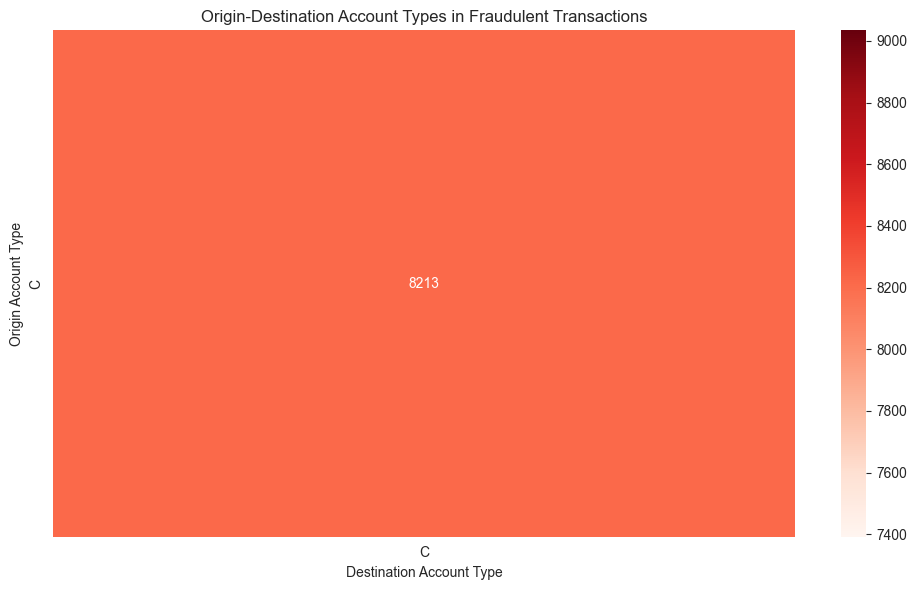

In [36]:
# Analyze origin-destination combinations in fraudulent transactions
fraud_data = data[data['isFraud'] == 1]
fraud_od_pairs = pd.crosstab(fraud_data['originAccountType'], fraud_data['destAccountType'])

plt.figure(figsize=(10, 6))

sns.heatmap(fraud_od_pairs, annot=True, cmap='Reds', fmt='d')
plt.title('Origin-Destination Account Types in Fraudulent Transactions')
plt.xlabel('Destination Account Type')
plt.ylabel('Origin Account Type')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sender Balance Delta vs Fraud')

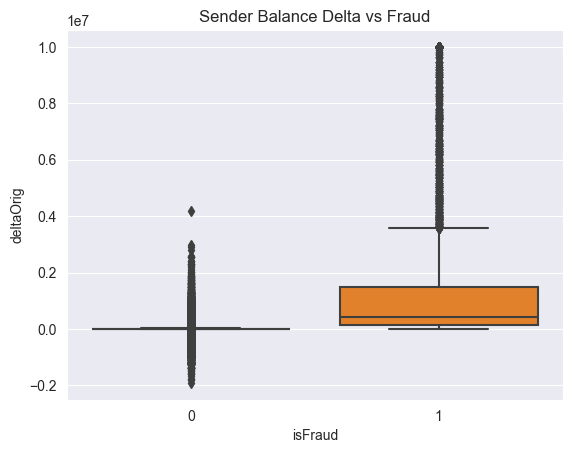

In [16]:
# Visualize how change in sender or recipient balances relate to fraud
data['deltaOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
sns.boxplot(data=data, x='isFraud', y='deltaOrig')
plt.title("Sender Balance Delta vs Fraud")

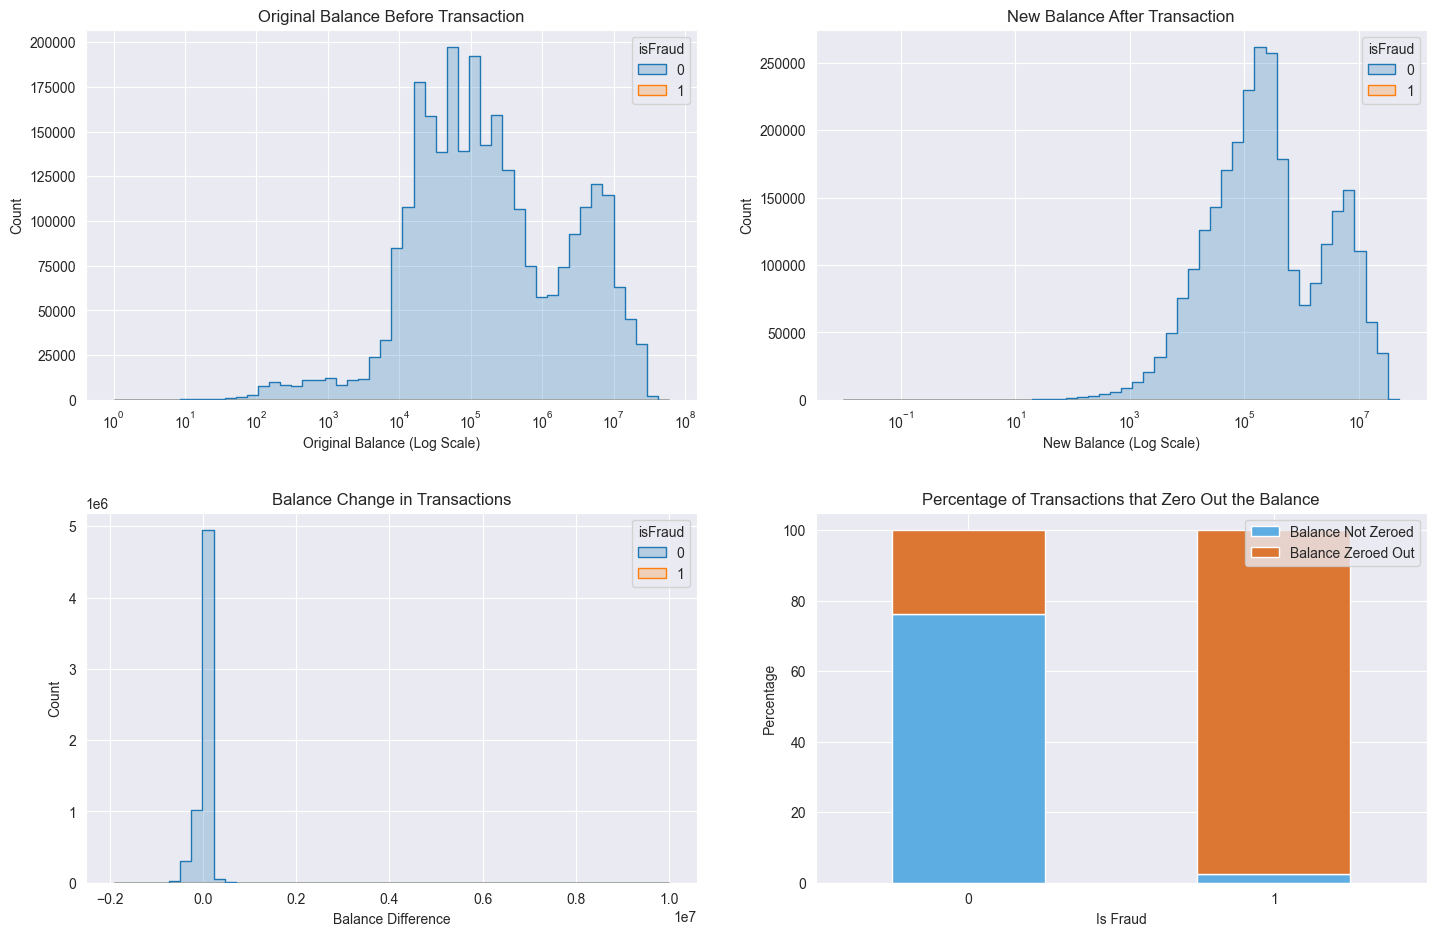

In [17]:
plt.figure(figsize=(15, 10))

# Only use positive balances for log-scale plots
data2 = data[(data['oldbalanceOrg'] > 0) & (data['newbalanceOrig'] > 0)]

# Original balance distribution
plt.subplot(2, 2, 1)
sns.histplot(data=data2, x='oldbalanceOrg', hue='isFraud',
            bins=50, log_scale=True, element="step")
plt.title('Original Balance Before Transaction')
plt.xlabel('Original Balance (Log Scale)')

# New balance distribution
plt.subplot(2, 2, 2)
sns.histplot(data=data2, x='newbalanceOrig', hue='isFraud',
            bins=50, log_scale=True, element="step")
plt.title('New Balance After Transaction')
plt.xlabel('New Balance (Log Scale)')


# Balance changes in transactions
plt.subplot(2, 2, 3)
sns.histplot(data=data, x='deltaOrig', hue='isFraud',
            bins=50, element="step")
plt.title('Balance Change in Transactions')
plt.xlabel('Balance Difference')



# Zero out balances
ax4 = plt.subplot(2, 2, 4)

# Check if the balance is zeroed out (as percentage of initial balance)
data['zeroedOut'] = (data['newbalanceOrig'] == 0) & (data['oldbalanceOrg'] > 0)
zero_out_by_fraud = pd.crosstab(data['isFraud'], data['zeroedOut'],
                              normalize='index') * 100


zero_out_by_fraud.plot(kind='bar', stacked=True, ax=ax4, color=['#5DADE2', '#DC7633'])
plt.title('Percentage of Transactions that Zero Out the Balance')
plt.xlabel('Is Fraud')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(['Balance Not Zeroed', 'Balance Zeroed Out'])

plt.tight_layout(pad=3.0)
# plt.savefig("BalanceAnalysis.png", dpi=300)
plt.show()

**Takeaways**
- `deltaOrig` reflects how much money was debited from the sender's account during the transaction.
- Fraudulent transactions (isFraud=1) have large consistent delta. We can infer from the higher median value, and wider IQR range compared to legitimate transactions (isFraud=0). This tells us that fraudsters typically withdraw larger amounts from the sender's account, reflecting possibility of full balance wipeouts or transfers with predictable rule-based amounts.
- Legitimate transactions (isFraud=0) shows erratic behavior with many close to zero deltas, meaning account balance may not change much. Legitimate transactions may vary a lot in delta balance, including negative deltas, possibly due to salary deposits or system adjustments.
- Fraud is only committed between customer accounts (C -> C). With this said, no fraudulent transactions involve Merchant (M) or other account types.
- Many fraudulent transactions completely empty the origin account balance.

#### Temporal Analysis

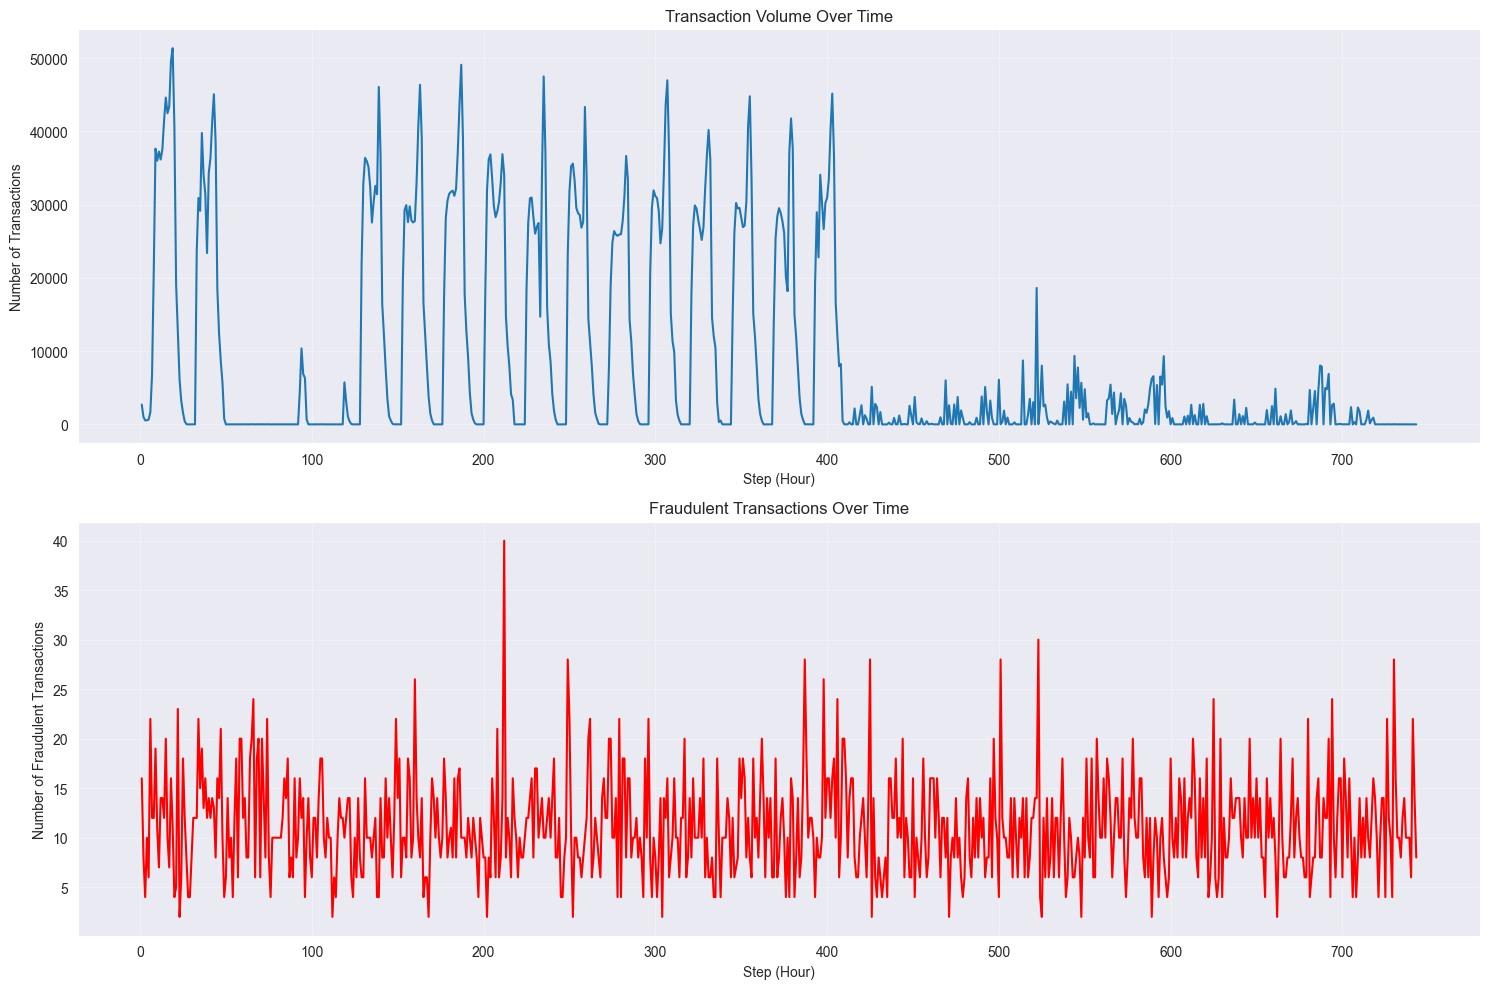

In [18]:
# Analyzing transaction patterns over time
plt.figure(figsize=(15, 10))

# Transactions per step (hour)
ax1 = plt.subplot(2, 1, 1)
data.groupby('step').size().plot(ax=ax1)
ax1.set_title('Transaction Volume Over Time')
ax1.set_xlabel('Step (Hour)')
ax1.set_ylabel('Number of Transactions')
ax1.grid(True, alpha=0.3)

# Fraud per step
ax2 = plt.subplot(2, 1, 2)
data[data['isFraud'] == 1].groupby('step').size().plot(color='red', ax=ax2)
ax2.set_title('Fraudulent Transactions Over Time')
ax2.set_xlabel('Step (Hour)')
ax2.set_ylabel('Number of Fraudulent Transactions')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig("TemporalAnalysis.png", dpi=300)
plt.show()

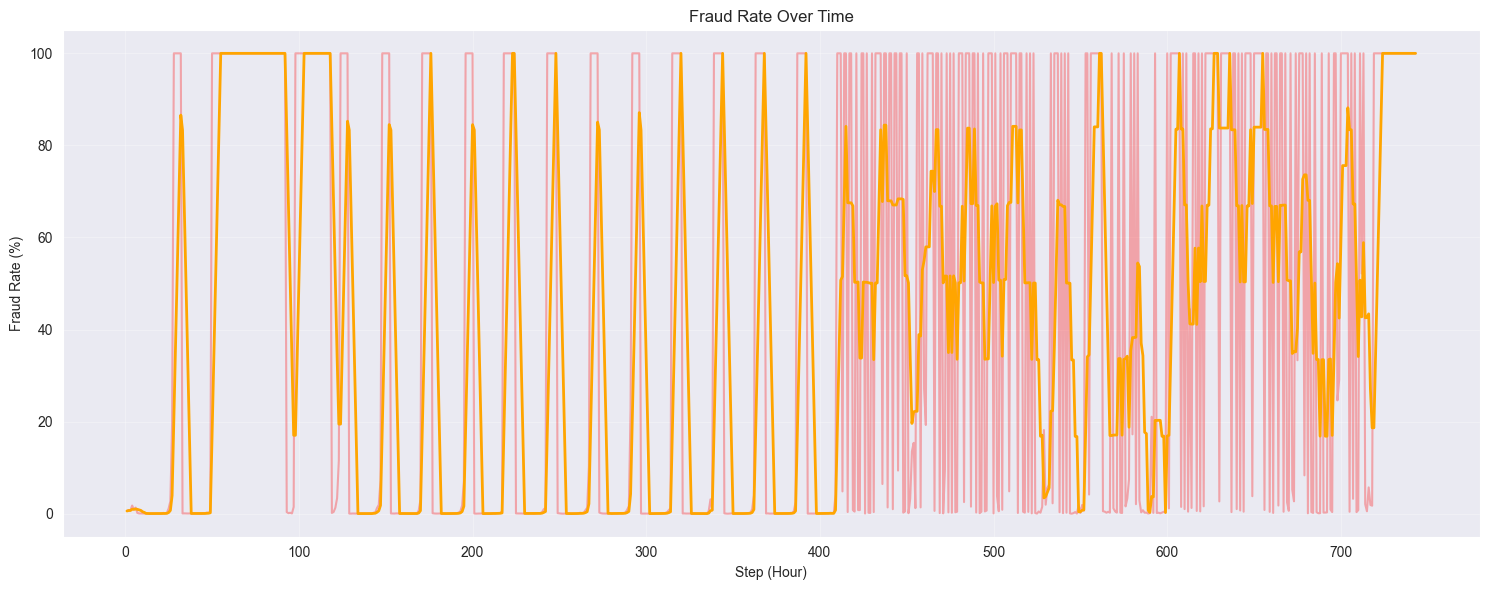

In [19]:
# Calculate fraud rate per step
steps = data.groupby('step')
fraud_rate = steps['isFraud'].mean() * 100
fraud_rate_smoothed = fraud_rate.rolling(window=6, min_periods=1).mean()   # uses 6-hour-rolling window

plt.figure(figsize=(15, 6))

fraud_rate.plot(color='red', alpha=0.3, label='Raw Fraud Rate')
fraud_rate_smoothed.plot(color='orange', linewidth=2, label='Smoothed Fraud Rate (6h MA)')
plt.title('Fraud Rate Over Time')
plt.xlabel('Step (Hour)')
plt.ylabel('Fraud Rate (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig("FraudRateOverTime.png", dpi=300)
plt.show()

**Takeaways**
1. Transaction Volume Over Time
- There's a clear periodicity with repeated sharp spikes and valleys up to around step 400. From that point onwards transaction volume drops significantly and becomes erratic.
- Daily cycles in transaction activity are clearly observed (business hours vs night time) throughout the steps.

2. Fraudulent Transactions Over Time
- Despite changes in total transaction volume observed in the first plot, fraud activity remains relatively stable, ranging between 5-25 cases per hour.
- A spike in fraud transactions (40 frauds in a single hour around step 230) was observed.
- Fraud volume is weakly correlated with overall transaction volume, suggesting that fraud occurs consistently as if the transactions were run on script or automated to avoid detection through volume anomalies.
- Frausters may also exploit low-traffic periods (post step 400) to avoid getting flagged during busy hours.

3. Fraud Rate Over Time
- Low-volume hours are highly prone to fraud activities, seeing that the fraud percentage becomes more volatile after step 400. This potentially suggests fraudsters were prolonging attack scenarios to test fraud detection response.
- Fraud rate appears to have smoother cycles before step 400, which implies that fraud follows a potentially scripted and periodic behavior – peaking repetitively every 20-30 hours.

### 3. Summary of Findings
- The PaySim dataset is highly imbalanced with fraudulent transactions making only a small percentage (0.13%) of the 6.3mil records.
- Fraud primarily occurs in `TRANSFER` and `CASH_OUT` transaction types.
- Fraudulent transactions typically involve larger amounts than legitimate transactions while consistently operating within a set range and avoiding extremely high amounts to avoid getting flagged.
- There appears to be a pattern where many fraudulent transactions completely wipeout the origin account balance.
- `isFlaggedFraud` feature only captures a small subset of actual fraudulent transactions, suggesting it's **not a reliable indicator** on its own.
- There are distinct patterns noted in how account balances change during fraudulent transactions, where fraudsters transfer money to another customer account and then cash out.
- Fraud activity appears to occur consistently every 20-30 hours pre-step 400, while maintaining a persistent baseline yet more erratic post-step 400.